In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from random import shuffle
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
#csv_table = pd.read_csv('out_soc-sign-bitcoinalpha.csv')
#csv_table = pd.read_csv('out_radoslaw_email_email.csv')
#csv_table = pd.read_csv('out_soc-sign-bitcoinotc.csv')
csv_table = pd.read_csv('email-Eu-core-temporal.csv')
#csv_table = pd.read_csv('out_opsahl-ucsocial.csv')
data = csv_table

In [ ]:
# отсортируем данные по времени, чтобы было удобно выделять статический граф
data = csv_table

t_start = min(data['time'])
t_end = max(data['time'])

history = data.sort_values(by='time', ascending=True)
history = history.reset_index(drop=True)

print(history[(np.percentile(history.time, 0) <= history.time) & (history.time <= np.percentile(history.time, 75))])

        from   to      time
0        582  364         0
1        168  472      2797
2        168  912      3304
3          2  790      4523
4          2  322      7926
...      ...  ...       ...
249246   166  126  36704869
249247   955  540  36704929
249248   868   30  36705328
249249   949  912  36705807
249250   949  168  36705807

[249251 rows x 3 columns]


In [ ]:
# создадим множество вершин, для построения в дальнейшем матрицы смежности
V = set()

for index, edge in data.iterrows():
  V.add(edge['from'])
  V.add(edge['to'])

print(V)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,

In [ ]:
print(len(V))

986


In [ ]:
# функция, возвращающая матрицу смежности для графа (преобразуется в неориентированный) в указанный период времени
def adjacency_matrix(H, V, t):
  H = H[(np.percentile(H.time, 0) <= H.time) & (H.time <= np.percentile(H.time, int(t*100)))]
  M = [[float('inf') for j in range(len(V))] for i in range(len(V))]
  for index, edge in H.iterrows():
    M[edge['from']-1][edge['to']-1] = edge['weight']
    M[edge['to']-1][edge['from']-1] = edge['weight']
 
  return M

In [ ]:
# Словарь
def adjacency_list(H, V, t):
  # ключ - from, значение - [to, weight, time, w_lin, w_exp, w_sqrt]
  H = H[(np.percentile(H.time, 0) <= H.time) & (H.time <= np.percentile(H.time, int(t*100)))]
  M = {}
  for v in V:
    M[v] = []
  for index, edge in H.iterrows():
    if not (edge['to'], 0, edge['time']) in M[edge['from']]:
      M[edge['from']].append((edge['to'], 0, edge['time']))
    if not (edge['from'], 0, edge['time']) in M[edge['to']]:
      M[edge['to']].append((edge['from'], 0, edge['time']))

  return M

In [ ]:
# функция, возвращающая список несмежных вершин в указанный период времени

def non_adjacent_vertices(H, V, t):

  base_set = set()
  V = list(V)
  for i in range(len(V) - 1):
    for j in range(i + 1, len(V)):
      base_set.add(frozenset([V[i], V[j]]))
  
  H = H[(np.percentile(H.time, 0) <= H.time) & (H.time <= np.percentile(H.time, int(t*100)))]

  for index, edge in H.iterrows():
    if frozenset([edge['from'], edge['to']]) in base_set:
      base_set.remove(frozenset([edge['from'], edge['to']]))
  
  out_set = set()

  for pair in base_set:
    out_set.add(tuple(pair))
  
  return list(out_set)
  

In [ ]:
NV = non_adjacent_vertices(history, V, 0.5)

In [ ]:
AM = adjacency_list(history, V, 1)

In [ ]:
s = set()

for item in AM:
  for i in range(len(AM[item])):
    s.add(frozenset([item, AM[item][i][0], AM[item][i][2]]))
len(s)

327333

In [ ]:
print(len(NV))

474715


In [ ]:
#print(AM[NV[0][0]-1][NV[0][1]-1] != float('inf')) # Проверим, появится ли ребро в последствии, или нет для матрицы

In [ ]:
def check(nv, M): # для словаря

  for v in AM[nv[0]]:
    if v[0] == nv[1]:
      return 1
  return 0

print(check(NV[0], AM))

0


# **Static topological features (I)**

In [ ]:
# Common Neighbours
def CN(u, v, G):
  return len(set(G[u])&set(G[v]))

In [ ]:
# Adamic-Adar
def degree(v, G):
  if v in G:
    return len(G[v])
  else:
    return 0

def AA(u, v, G):
  common_list = list(set(G[u])&set(G[v]))
  s = 0
  for item in common_list:
    s += 1/math.log(degree(item[0], G))

  return s

In [ ]:
# Jaccard Coefficient
def JC(u, v, G):
  if len(set(G[u]+G[v])) == 0:
    return 0
  else:
    return len(set(G[u])&set(G[v]))/len(set(G[u]+G[v]))

In [ ]:
# Preferential  Attachment
def PA(u, v, G):
  return len(G[u])*len(G[v])

# **Node activity features (III)**

In [ ]:
# Выделим на времени 0.5 статический граф, 75% которого возьмем для обучения, остальную часть для тестов.
AM_t = adjacency_list(history, V, 0.75)
NV_t = non_adjacent_vertices(history, V, 0.75)

In [ ]:
# Взвесим каждую вершину
l = 0.75
t_start = min(data['time'])
t_end = max(data['time'])
for v in AM_t:
  for u in range(len(AM_t[v])):
    time = (AM_t[v][u][2]-t_start)/(t_end-t_start)
    # + w_lin, w_exp, w_sqrt <=>  3, 4, 5
    AM_t[v][u] = (AM_t[v][u][0], AM_t[v][u][1], AM_t[v][u][2], l+(1-l)*time, l+(1-l)*((math.exp(3*time)-1)/(math.exp(3)-1)), l+(1-l)*math.sqrt(time)) 

V_weighed = {}

for v in V:
  w_lin = []
  w_exp = []
  w_sqrt = []
  for u in AM_t[v]:
    w_lin.append(u[3])
    w_exp.append(u[4])
    w_sqrt.append(u[5])
  if AM_t[v]:
    V_weighed[v] = [np.percentile(w_lin, 0), np.percentile(w_lin, 25), np.percentile(w_lin, 50), np.percentile(w_lin, 75), np.percentile(w_lin, 100), sum(w_lin), np.mean(w_lin)]
    V_weighed[v] += [np.percentile(w_exp, 0), np.percentile(w_exp, 25), np.percentile(w_exp, 50), np.percentile(w_exp, 75), np.percentile(w_exp, 100), sum(w_exp), np.mean(w_exp)]
    V_weighed[v] += [np.percentile(w_sqrt, 0), np.percentile(w_sqrt, 25), np.percentile(w_sqrt, 50), np.percentile(w_sqrt, 75), np.percentile(w_sqrt, 100), sum(w_sqrt), np.mean(w_sqrt)]
  else:
    V_weighed[v] = [0 for i in range(21)]


# **ФОРМИРОВАНИЕ ДАННЫХ**

In [ ]:
answers = {}
for edge in NV_t:
  answers[edge] = check(edge, AM)

In [ ]:
c1 = 0
c0 = 0
for key in answers:
  if answers[key]:
    c1 += 1
  else:
    c0 += 1

print(c1, c0)
print(c0/c1)
# В 1000 (!) больше непоявившихся ребер

2621 469541
179.14574589851202


In [ ]:
# разделим датасет
appear = []
not_appear = []
for edge in NV_t:
  if answers[edge]:
    appear.append(edge)
  else:
    not_appear.append(edge)

In [ ]:
shuffle(not_appear)
NV_t = not_appear[:len(appear)]
NV_t += appear
shuffle(NV_t)
train_set = NV_t[:int(len(NV_t)*0.75)]
test_set = NV_t[int(len(NV_t)*0.75):]

In [ ]:
print(len(not_appear[:len(appear)]))

2621


In [ ]:
# Создадим словарь признаков с несмежными вершинами в качестве ключей
features_I = {}
for edge in NV_t:
  u = edge[0]
  v = edge[1]
  features_I[edge] = [CN(u, v, AM_t), AA(u, v, AM_t), JC(u, v, AM_t), PA(u, v, AM_t)]

In [ ]:
features_III = {}
for edge in NV_t:
  u = edge[0]
  v = edge[1]
  base = []
  for i in range(21):
    base += [V_weighed[u][i] + V_weighed[v][i], abs(V_weighed[u][i] - V_weighed[v][i]), max(V_weighed[u][i],V_weighed[v][i]), min(V_weighed[u][i],V_weighed[v][i])]
  base += features_I[edge]
  features_III[edge] = base

# **обучение**
c фичами I


In [ ]:
X_train = []
Y_train = []
shuffle(train_set)
for key in train_set:
  X_train.append(features_I[key])
  Y_train.append(answers[key])
  
X_test = []
Y_test = []
shuffle(test_set)
for key in test_set:
  X_test.append(features_I[key])
  Y_test.append(answers[key])

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)


LogisticRegression()

In [ ]:
Y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.49


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[ 60 593]
 [ 78 580]]


In [ ]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.43      0.09      0.15       653
           1       0.49      0.88      0.63       658

    accuracy                           0.49      1311
   macro avg       0.46      0.49      0.39      1311
weighted avg       0.46      0.49      0.39      1311



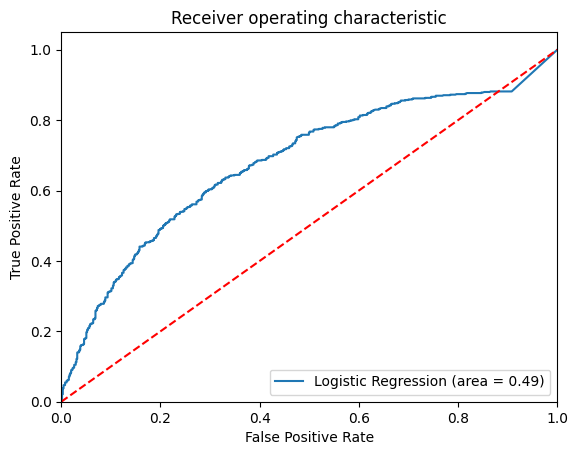

In [ ]:
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# **обучение**
с фичами III

In [ ]:
X_train = []
Y_train = []
shuffle(train_set)
for key in train_set:
  X_train.append(features_III[key])
  Y_train.append(answers[key])
  
X_test = []
Y_test = []
shuffle(test_set)
for key in test_set:
  X_test.append(features_III[key])
  Y_test.append(answers[key])

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)


LogisticRegression()

In [ ]:
Y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.51


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[  8 645]
 [  3 655]]


In [ ]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.73      0.01      0.02       653
           1       0.50      1.00      0.67       658

    accuracy                           0.51      1311
   macro avg       0.62      0.50      0.35      1311
weighted avg       0.62      0.51      0.35      1311



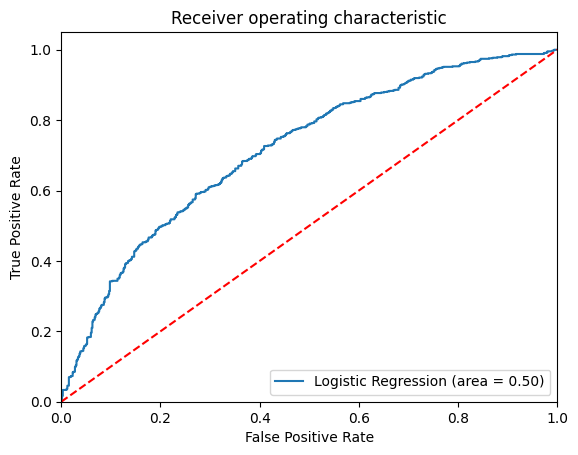

In [ ]:
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()